Tristan Hoellinger<br/>
Institut d'Astrophysique de Paris</br>
tristan.hoellinger@iap.fr

# Exploring time step limiters for P3M: tuning $\eta$

## Set up the environment and parameters

In [1]:
# pyright: reportWildcardImportFromLibrary=false
from wip3m import *

In [2]:
workdir = ROOT_PATH + "results/"
output_path = OUTPUT_PATH

# STANDARD PARAMETERS:
L = 32  # Box size in Mpc/h
N = 32  # Density grid size
Np = 32  # Number of dark matter particles per spatial dimension
Npm = 64  # PM grid size
n_Tiles = 8  # Make sure Npm/n_Tiles >= 6
    
force = force_hard = True
run_id = "notebook12"

TimeStepDistribution = 3  # 0: constant, 1: log, 2: exp, 3: custom
# nsteps = 0  # not used for TimeStepDistribution=3

In [3]:
# Automatic reloading of modules
%load_ext autoreload
%autoreload 2

from os.path import isfile
from pathlib import Path
import numpy as np

from pysbmy.power import PowerSpectrum
from pysbmy.field import read_field
from pysbmy.timestepping import StandardTimeStepping, P3MTimeStepping

from wip3m.tools import get_k_max, generate_sim_params, generate_white_noise_Field, run_simulation
from wip3m.params import params_CONCEPT_kmax_missing, cosmo_small_to_full_dict, z2a, BASELINE_SEEDPHASE
from wip3m.plot_utils import *  # type: ignore

In [4]:
corner = 0.0
RedshiftLPT = 19.0
RedshiftFCs = 0.0

ai = z2a(RedshiftLPT)
af = z2a(RedshiftFCs)
k_max = get_k_max(L, N)  # k_max in h/Mpc
print(f"k_max = {k_max}")
# cosmo = params_planck_kmax_missing.copy()
cosmo = params_CONCEPT_kmax_missing.copy()
cosmo["k_max"] = k_max

wd = workdir + run_id + "/"
simdir = output_path + run_id + "/"
gravpotdir = simdir + "gravpot/"
momentadir = simdir + "p_res/"
logdir = simdir + "logs/"
if force_hard:
    import shutil
    if Path(simdir).exists():
        shutil.rmtree(simdir)
    if Path(wd).exists():
        shutil.rmtree(wd)
Path(wd).mkdir(parents=True, exist_ok=True)
Path(gravpotdir).mkdir(parents=True, exist_ok=True)
Path(momentadir).mkdir(parents=True, exist_ok=True)
Path(logdir).mkdir(parents=True, exist_ok=True)

input_white_noise_file = simdir + "input_white_noise.h5"
input_seed_phase_file = simdir + "seed"
ICs_path = simdir + "initial_density.h5"
simpath = simdir

# Path to the input matter power spectrum (generated later)
input_power_file = simdir + "input_power.h5"

# Paths to the time step logs
OutputTimestepsLog = simdir + "timesteps_log.txt"

# Path to the output gravitational potential field
OutputGravitationalPotentialBase = gravpotdir + "gp"

# Path to the output momenta field
OutputMomentaBase = momentadir + "p"

k_max = 5.442


### Generate the parameter files

In [5]:
common_params = {
    "Np": Np,
    "N": N,
    "L": L,
    "corner0": corner,
    "corner1": corner,
    "corner2": corner,
    "h": cosmo["h"],
    "Omega_m": cosmo["Omega_m"],
    "Omega_b": cosmo["Omega_b"],
    "n_s": cosmo["n_s"],
    "sigma8": cosmo["sigma8"],
}

lpt_params = common_params.copy()
lpt_params["method"] = "lpt"
lpt_params["InputPowerSpectrum"] = input_power_file
lpt_params["ICsMode"] = 1
lpt_params["InputWhiteNoise"] = input_white_noise_file

p3m_fit_coeffs = P3M_FIT_COEFFS_DEFAULT_2NP

fac_dyn = DEFAULT_FAC_DYN_CUSTOM_COLA
fac_hubble = DEFAULT_FAC_H_CUSTOM_COLA
fac_bend = DEFAULT_FAC_BEND
sub_bend1 = DEFAULT_SUB_BEND1_COLA
sub_bend2 = DEFAULT_SUB_BEND2_COLA
fac_p3m_fit = DEFAULT_FAC_P3M_FIT
da_early = DEFAULT_DA_MAX_EARLY_CUSTOM
p3m_params = common_params.copy()
p3m_params["method"] = "p3m"
p3m_params["EvolutionMode"] = 7  # 7: COLA with P3M force evaluation
p3m_params["TimeStepDistribution"] = 3
p3m_params["ai"] = ai
p3m_params["af"] = af
p3m_params["RedshiftLPT"] = RedshiftLPT
p3m_params["RedshiftFCs"] = RedshiftFCs
p3m_params["Npm"] = Npm
p3m_params["n_Tiles"] = n_Tiles
p3m_params["RunForceDiagnostic"] = False
p3m_params["PrintOutputTimestepsLog"] = True
p3m_params["OutputTimestepsLog"] = OutputTimestepsLog
p3m_params["cosmo_dict"] = cosmo
p3m_params["fac_dyn_custom"] = fac_dyn
p3m_params["fac_H_custom"] = fac_hubble
p3m_params["fac_bend"] = fac_bend
p3m_params["sub_bend1"] = sub_bend1
p3m_params["sub_bend2"] = sub_bend2
p3m_params["fac_p3m_fit"] = fac_p3m_fit
p3m_params["da_max_early_custom"] = da_early
p3m_params["da_max_late_custom"] = DEFAULT_DA_MAX_LATE_CUSTOM  # da_late
p3m_params["p3m_fit_coeffs"] = p3m_fit_coeffs
p3m_params["use_p3m_fit"] = True
p3m_params["WriteGravPot"] = True
p3m_params["OutputGravitationalPotentialBase"] = OutputGravitationalPotentialBase
p3m_params["WriteReferenceFrame"] = True
p3m_params["OutputMomentaBase"] = OutputMomentaBase
file_ext = None

[09:46:16|INFO      ]|(wip3m.tools) Generating parameter file...
[09:46:16|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook12/example_lpt.sbmy'...
[09:46:16|STATUS    ]|Writing parameter file in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook12/example_lpt.sbmy' done.
[09:46:16|INFO      ]|(wip3m.tools) Parameter file written to /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook12/example_lpt.sbmy
[09:46:16|INFO      ]|(wip3m.tools) Time-stepping distribution file: /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook12/ts_p3m.h5
[09:46:16|STATUS    ]|Write custom timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these

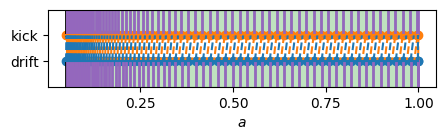

In [6]:
reset_plotting()  # Default style for Simbelmynë
generate_sim_params(lpt_params, ICs_path, wd, simdir, None, force)
generate_sim_params(p3m_params, ICs_path, wd, simdir, file_ext, force)
setup_plotting()  # Reset plotting style for this project

In [7]:
TSpath = wd + file_ext + "_ts_p3m.h5" if file_ext else wd + "ts_p3m.h5"
if TimeStepDistribution in [0, 1, 2]:
    TS = StandardTimeStepping.read(TSpath)
    aiDrift = TS.aiDrift
    nsteps = TS.nsteps
elif TimeStepDistribution == 3:
    TS = P3MTimeStepping.read(TSpath)
    aiDrift = TS.aiDrift
    nsteps = TS.nsteps
else:
    raise ValueError(f"Invalid TimeStepDistribution: {TimeStepDistribution}")

[09:46:17|STATUS    ]|Read custom timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook12/ts_p3m.h5'...
[09:46:17|STATUS    ]|Read custom timestepping configuration in '/Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook12/ts_p3m.h5' done.


### Generate the initial phase

In [8]:
generate_white_noise_Field(
    L=L,
    size=N,
    corner=corner,
    seedphase=BASELINE_SEEDPHASE,
    fname_whitenoise=input_white_noise_file,
    seedname_whitenoise=input_seed_phase_file,
    force_phase=force,
)

### Generating the input power spectrum

In [9]:
# If cosmo["WhichSpectrum"] == "class", then classy is required.
if not isfile(input_power_file) or force:
    Pk = PowerSpectrum(L, L, L, N, N, N, cosmo_small_to_full_dict(cosmo))
    Pk.write(input_power_file)

[09:46:17|STATUS    ]|Setting up Fourier grid...
[09:46:17|STATUS    ]|Setting up Fourier grid done.
[09:46:17|[09:46:17|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook12/input_power.h5'...
STATUS    ]|Computing normalization of the power spectrum...
[09:46:17|STATUS    ]|Computing normalization of the power spectrum done.
[09:46:17|STATUS    ]|Computing power spectrum...
[09:46:17|STATUS    ]|Computing power spectrum done.
[09:46:17|DIAGNOSTIC]==|L0=32, L1=32, L2=32
[09:46:17|DIAGNOSTIC]==|N0=32, N1=32, N2=32, N2_HC=17, N_HC=17408, NUM_MODES=464
[09:46:17|STATUS    ]|Write power spectrum in data file '/Users/hoellinger/WIP3M/notebook12/input_power.h5' done.


## Running the simulations

In [10]:
run_simulation("lpt", lpt_params, wd, logdir)

[09:46:17|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook12/example_lpt.sbmy /Users/hoellinger/WIP3M/notebook12/logs/lpt.txt
[09:46:17|INFO      ]|
[09:46:17|INFO      ]|            .-~~-.--.
[09:46:17|INFO      ]|           :         )
[09:46:17|INFO      ]|     .~ ~ -.\       /.- ~~ .
[09:46:17|INFO      ]|     >       `.   .'       <
[09:46:17|INFO      ]|    (         .- -.         )
[09:46:17|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[09:46:17|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[09:46:17|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[09:46:17|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[09:46:17|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[09:46:17|INFO      ]|     

In [11]:
run_simulation("p3m", p3m_params, wd, logdir)

[09:46:17|COMMAND   ]|simbelmyne /Users/hoellinger/Library/CloudStorage/Dropbox/travail/these/science/code/simbelmyne/simbelmyne2025/WIP_P3M/results/notebook12/example_p3m.sbmy /Users/hoellinger/WIP3M/notebook12/logs/p3m.txt
[09:46:17|INFO      ]|
[09:46:17|INFO      ]|            .-~~-.--.
[09:46:17|INFO      ]|           :         )
[09:46:17|INFO      ]|     .~ ~ -.\       /.- ~~ .
[09:46:17|INFO      ]|     >       `.   .'       <
[09:46:17|INFO      ]|    (         .- -.         )
[09:46:17|INFO      ]|     `- -.-~  `- -'  ~-.- -'
[09:46:17|INFO      ]|       (        :        )           _ _ .-:        ___________________________________
[09:46:17|INFO      ]|        ~--.    :    .--~        .-~  .-~  }                    SIMBELMYNË
[09:46:17|INFO      ]|            ~-.-^-.-~ \_      .~  .-~   .~           (c) Florent Leclercq 2012 - SBMY_YEAR 
[09:46:17|INFO      ]|                     \ '     \ '_ _ -~              ___________________________________
[09:46:17|INFO      ]|     

## Gravitational potential

In [12]:
slice_ijk = (N // 2, slice(None), slice(None))
steps = [1,38,75]  # Steps to compare
DELTA_P3M = read_field(simdir + f"final_density_p3m.h5").data[slice_ijk]
DELTA_GP1 = read_field(gravpotdir + f"gp_nforce{steps[0]}.h5").data[slice_ijk]
DELTA_GP2 = read_field(gravpotdir + f"gp_nforce{steps[1]}.h5").data[slice_ijk]
DELTA_GP3 = read_field(gravpotdir + f"gp_nforce{steps[2]}.h5").data[slice_ijk]
diff_gp2_gp1 = DELTA_GP3 - DELTA_GP1
diff_gp3_gp1 = DELTA_GP3 - DELTA_GP2

[09:46:25|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/final_density_p3m.h5'...
[09:46:25|DIAGNOSTIC]==|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int32(32), np.int32(32), np.int32(32)]
[09:46:25|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/final_density_p3m.h5' done.
[09:46:25|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/gravpot/gp_nforce1.h5'...
[09:46:25|DIAGNOSTIC]==|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int32(32), np.int32(32), np.int32(32)]
[09:46:25|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/gravpot/gp_nforce1.h5' done.
[09:46:25|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/gravpot/gp_nforce38.h5'...
[09:46:25|DIAGNOSTIC]==|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32

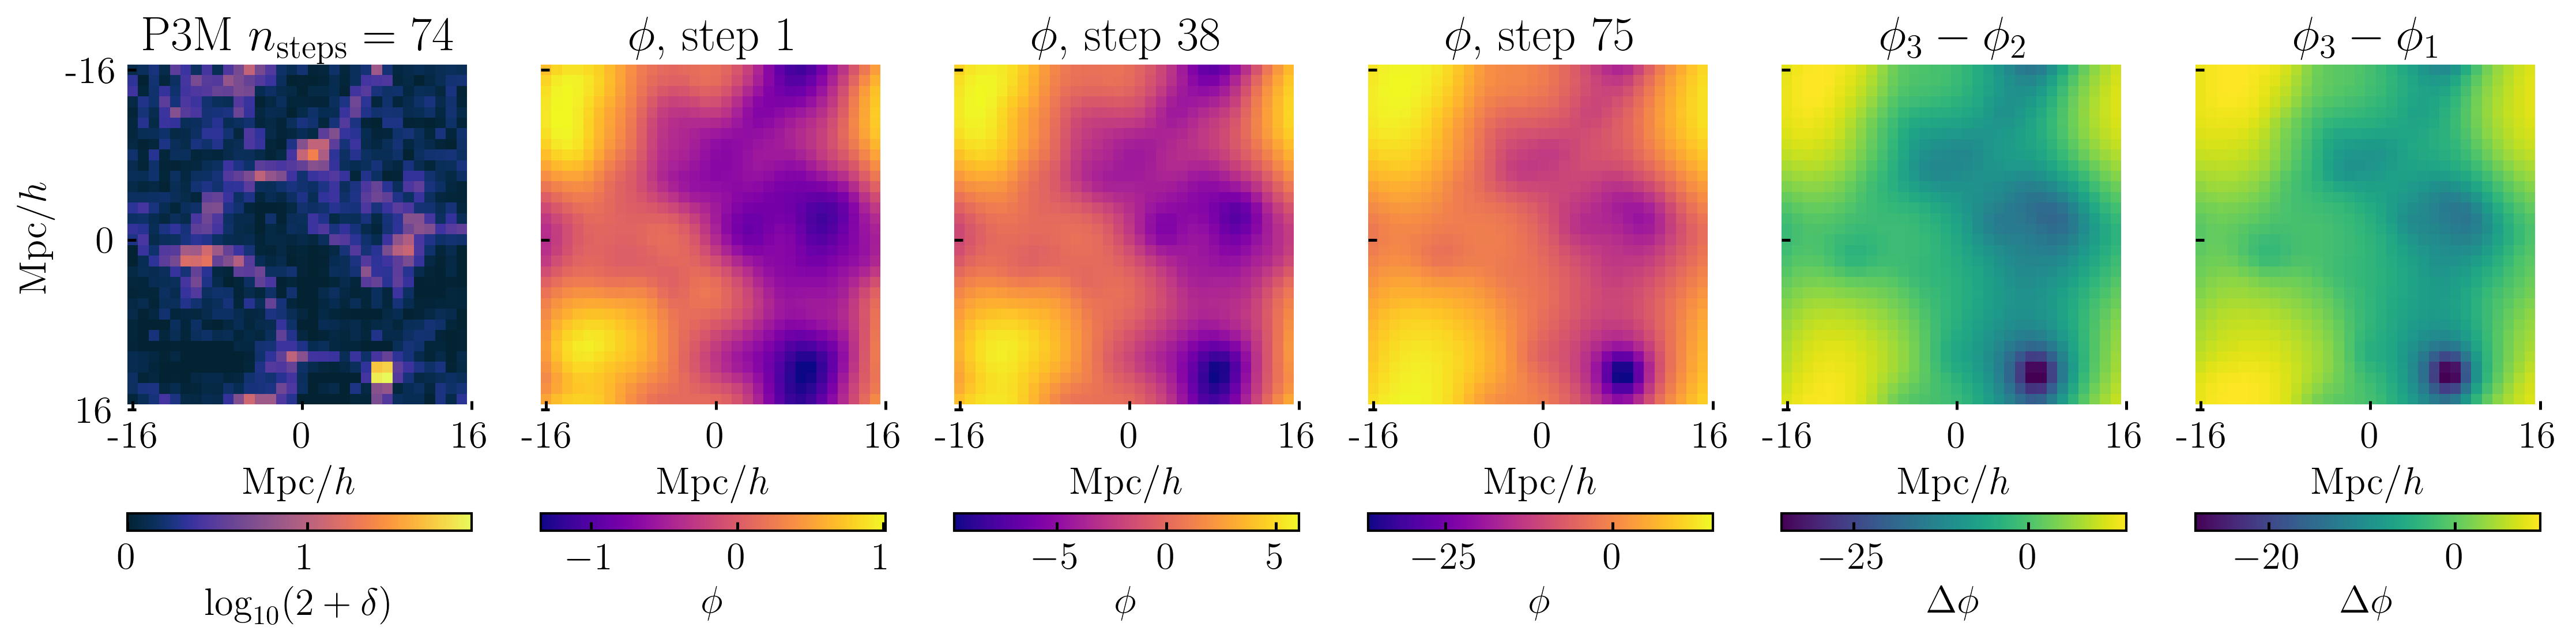

In [13]:
fields = ["p3m", "gp1", "gp2", "gp3", "diff_gp2_gp1", "diff_gp3_gp1"]  # fields to plot

figname = "_".join(fields)
slices_dict = {
    "p3m": DELTA_P3M,
    "gp1": DELTA_GP1,
    "gp2": DELTA_GP2,
    "gp3": DELTA_GP3,
    "diff_gp2_gp1": diff_gp2_gp1,
    "diff_gp3_gp1": diff_gp3_gp1,
}
titles_dict = {
    "p3m": f"P3M $n_\\mathrm{{steps}}={nsteps}$",
    "gp1": rf"$\phi$, step {steps[0]}",
    "gp2": rf"$\phi$, step {steps[1]}",
    "gp3": rf"$\phi$, step {steps[2]}",
    "diff_gp2_gp1": r"$\phi_3 - \phi_2$",
    "diff_gp3_gp1": r"$\phi_3 - \phi_1$",
}

npanels = len(fields)
fig, axs = plt.subplots(1, npanels, figsize=(3 * npanels, 4), sharey=True)

ims = []
for i, key in enumerate(fields):
    ax = axs[i]
    data = slices_dict[key]
    title = titles_dict[key]

    if key.startswith("diff"):
        im = ax.imshow(data, cmap="viridis")
    elif key.startswith("gp"):
        im = ax.imshow(data, cmap="plasma")
        # im = ax.imshow(np.log10(1 + data - np.min(data)), cmap="plasma")
    else:
        im = ax.imshow(np.log10(2 + data), cmap=cmap)

    ims.append((im, key))
    ax.set_title(title, fontsize=fs_titles)
    for spine in ax.spines.values():
        spine.set_visible(False)

axs[0].set_yticks([0, N // 2, N])
axs[0].set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
axs[0].set_ylabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for i, ax in enumerate(axs):
    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
    ax.set_xlabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for ax, (im, key) in zip(axs, ims):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    if key.startswith("gp"):
        cb.set_label(r"$\phi$", fontsize=fs)
    elif key.startswith("diff"):
        cb.set_label(r"$\Delta\phi$", fontsize=fs)
    else:
        cb.set_label(r"$\log_{10}(2 + \delta)$", fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    cax.xaxis.set_ticks_position("bottom")
    cax.xaxis.set_label_position("bottom")
fig.savefig(
    simdir + f"{figname}.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + f"{figname}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

## Residual momenta

In [14]:
component = 0
slice_cijk = (component, N // 2, slice(None), slice(None))
steps = [5,37,74]  # Steps to compare
DELTA_P1 = read_field(momentadir + f"p{steps[0]}.h5").data[slice_cijk]
DELTA_P2 = read_field(momentadir + f"p{steps[1]}.h5").data[slice_cijk]
DELTA_P3 = read_field(momentadir + f"p{steps[2]}.h5").data[slice_cijk]

[09:46:27|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/p_res/p5.h5'...
[09:46:27|DIAGNOSTIC]==|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int32(32), np.int32(32), np.int32(32)]
[09:46:27|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/p_res/p5.h5' done.
[09:46:27|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/p_res/p37.h5'...
[09:46:27|DIAGNOSTIC]==|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int32(32), np.int32(32), np.int32(32)]
[09:46:27|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/p_res/p37.h5' done.
[09:46:27|STATUS    ]|Read field in data file '/Users/hoellinger/WIP3M/notebook12/p_res/p74.h5'...
[09:46:27|DIAGNOSTIC]==|ranges=[np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.float64(0.0), np.float64(32.0), np.int

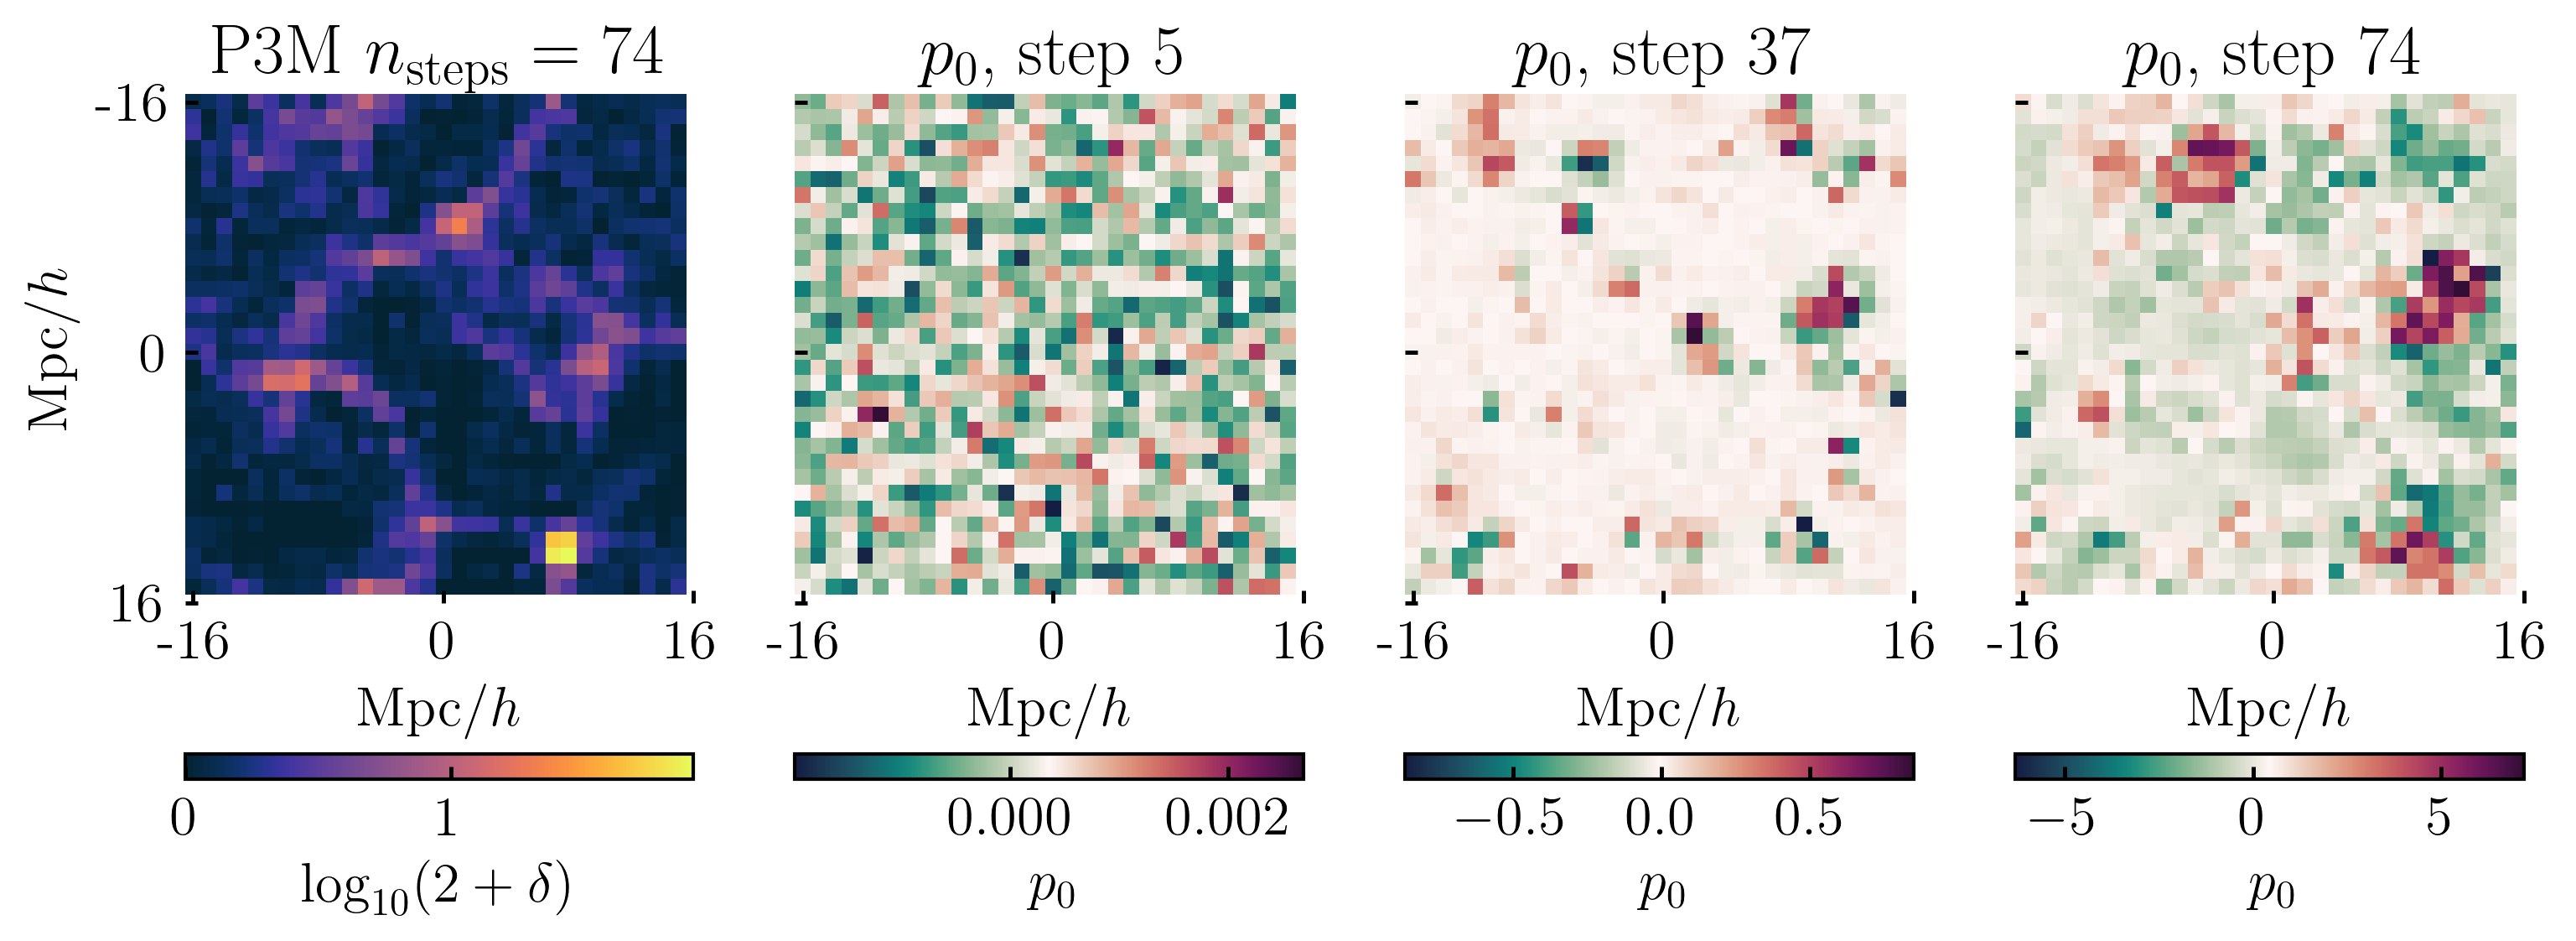

In [15]:
fields = ["p3m", "p1", "p2", "p3"]
figname = "_".join(fields)
slices_dict = {
    "p3m": DELTA_P3M,
    "p1": DELTA_P1,
    "p2": DELTA_P2,
    "p3": DELTA_P3,
}
titles_dict = {
    "p3m": f"P3M $n_\\mathrm{{steps}}={nsteps}$",
    "p1": rf"$p_{component}$, step {steps[0]}",
    "p2": rf"$p_{component}$, step {steps[1]}",
    "p3": rf"$p_{component}$, step {steps[2]}",
}

npanels = len(fields)
fig, axs = plt.subplots(1, npanels, figsize=(3 * npanels, 4), sharey=True)

ims = []
for i, key in enumerate(fields):
    ax = axs[i]
    data = slices_dict[key]
    title = titles_dict[key]

    if key.startswith("diff"):
        im = ax.imshow(data, cmap=cm.balance)
    elif key.startswith("p3m"):
        im = ax.imshow(np.log10(2 + data), cmap=cmap)
    else:
        im = ax.imshow(data, cmap=cm.curl)

    ims.append((im, key))
    ax.set_title(title, fontsize=fs_titles)
    for spine in ax.spines.values():
        spine.set_visible(False)

axs[0].set_yticks([0, N // 2, N])
axs[0].set_yticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
axs[0].set_ylabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for i, ax in enumerate(axs):
    ax.set_xticks([0, N // 2, N])
    ax.set_xticklabels([f"{-L/2:.0f}", "0", f"{L/2:.0f}"], fontsize=fs)
    ax.set_xlabel(r"Mpc/$h$", size=GLOBAL_FS_SMALL)

for ax, (im, key) in zip(axs, ims):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    if key.startswith("p3m"):
        cb.set_label(r"$\log_{10}(2 + \delta)$", fontsize=fs)
    elif key.startswith("diff"):
        cb.set_label(r"$\Delta\phi$", fontsize=fs)
    else:
        cb.set_label(rf"$p_{component}$", fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    cax.xaxis.set_ticks_position("bottom")
    cax.xaxis.set_label_position("bottom")
fig.savefig(
    simdir + f"{figname}.png",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
fig.savefig(
    simdir + f"{figname}.pdf",
    bbox_inches="tight",
    dpi=300,
)
plt.show()

## Time stepping diagnostic

In [16]:
a, _, _, _, _, da_p3m, da_p3m_fit, _, _, _ = np.loadtxt(
    OutputTimestepsLog[:-4] + "_custom.txt", delimiter=",", unpack=True, skiprows=0
)

[09:46:28|INFO      ]|(wip3m.plot_utils) Plotting timestep limiters from /Users/hoellinger/WIP3M/notebook12/timesteps_log.txt and /Users/hoellinger/WIP3M/notebook12/timesteps_log_custom.txt...
[09:46:28|INFO      ]|(wip3m.plot_utils) Plotting timestep limiters from /Users/hoellinger/WIP3M/notebook12/timesteps_log.txt and /Users/hoellinger/WIP3M/notebook12/timesteps_log_custom.txt done.


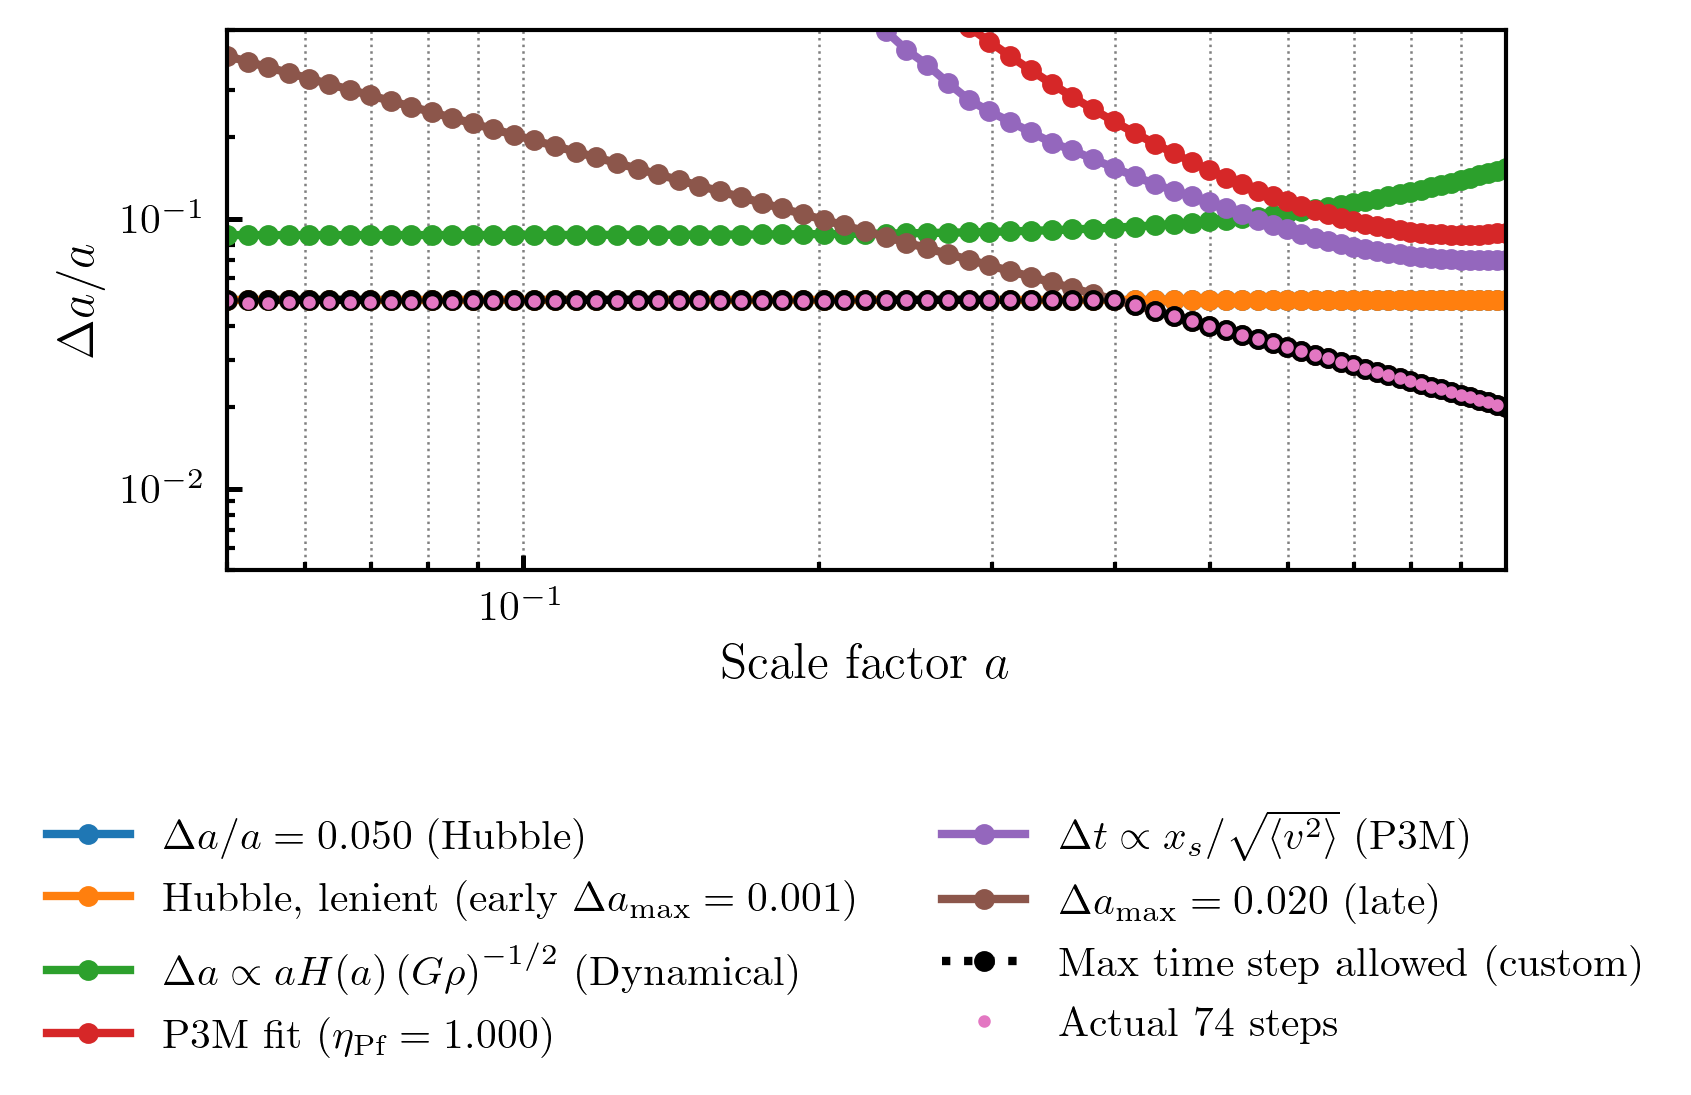

In [17]:
plot_custom_timestepping_diagnostics(
    log_path=OutputTimestepsLog,
    aiDrift=aiDrift,
    TimeStepDistribution=TimeStepDistribution,
    nsteps=nsteps,
    ymin=5e-3,
    ymax=0.5,
    fac_hubble=fac_hubble,
    plot_bend=False,
    fac_p3m_fit=fac_p3m_fit,
    da_max_early=da_early,
    da_max_late=DEFAULT_DA_MAX_LATE_CUSTOM,
)

In [18]:
# Delta a/a = cst => da = cst * a
cst = (aiDrift[-2]-aiDrift[-3]) / aiDrift[-3]

# a_nsteps = aiDrift[0] * (1 + cst)**nsteps
# 1 = a_nsteps => 1 = aiDrift[0] * (1 + cst)**nsteps
nsteps_needed = int(np.ceil(np.log(af/aiDrift[0]) / np.log(1 + cst)))
print(f"Number of log steps needed to reach af={af} from ai={aiDrift[0]}: {nsteps_needed}")

Number of log steps needed to reach af=1.0 from ai=0.05: 146
